In [44]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [45]:

#on ajoute notre fichier geoparquet
datafile ='/content/waaaa.geoparquet'
#on lit notre fichier geoparquet
data = gpd.read_parquet(datafile)
#add raw data table
geometry = gpd.points_from_xy(data['longitude'], data['latitude'])
gdf = gpd.GeoDataFrame(data, geometry=geometry)
fd=[gdf["latitude"],gdf["longitude"]]
fdd= gpd.GeoDataFrame(fd)

fdd=fdd.transpose()
fdd1=fdd["latitude"]
fdd2=fdd["longitude"]
fdd1=fdd1.values.tolist()
fdd2=fdd2.values.tolist()

temp=[gdf["temp_j0"]]
temp= gpd.GeoDataFrame(temp)

temp= temp.values.tolist()
y= np.array(fdd1)
x= np.array(fdd2)
z = np.array(temp[0])


In [46]:
# size of the grid to interpolate
nx, ny = 266, 251

# generate two arrays of evenly space data between ends of previous arrays
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.min(), y.max(), ny)

# generate grid
xi, yi = np.meshgrid(xi, yi)

# colapse grid into 1D
xi, yi = xi.flatten(), yi.flatten()

In [49]:
xi

array([-17.02820627, -16.96858532, -16.90896437, ...,  -1.3478958 ,
        -1.28827485,  -1.2286539 ])

In [50]:
def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536>
    """

    obs = np.vstack((x0, y0)).T

    interp = np.vstack((x1, y1)).T


    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    # calculate hypotenuse
    return np.hypot(d0, d1)

In [51]:
def simple_idw(x, y, z, xi, yi, power=1):
    """ Simple inverse distance weighted (IDW) interpolation
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """

    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance

    weights = 1.0/(dist+1e-12)**power

    print((weights.shape))
    value_to_replace = 1000000000000.0

    # Create a boolean mask for the value to replace
    mask = weights == value_to_replace

    # Replace the specific value with 0
    weights[mask] = 0

    # Make weights sum to one
    o=weights.sum(axis=0)

    weights = weights/o
    # Multiply the weights for each interpolated point by all observed Z-values
    t=np.dot(weights.T, z)
    a = t
    return a

In [52]:
def plot(x,y,z,grid):
    """ Plot the input points and the result """
    plt.figure(figsize=(15,10))
    plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()), cmap='rainbow', interpolation='gaussian')
    #plt.scatter(x,y,c=z, cmap='rainbow')
    plt.colorbar()

(1505, 66766)
[ 7.          7.00000018  7.00003069 ... 26.66773105 26.65831013
 26.6426216 ]
[[ 7.          7.00000018  7.00003069 ... 24.81327634 24.81674294
  24.8202288 ]
 [ 7.00000019  7.00000295  7.00009833 ... 24.81180144 24.81532423
  24.81886612]
 [ 7.00003419  7.00010436  7.00075419 ... 24.81031862 24.81389883
  24.81749798]
 ...
 [24.69178999 24.68896682 24.68608993 ... 26.67493624 26.65332692
  26.62508075]
 [24.69058265 24.68775825 24.68488093 ... 26.67191626 26.65719211
  26.6359036 ]
 [24.68945736 24.68663315 24.68375683 ... 26.66773105 26.65831013
  26.6426216 ]]


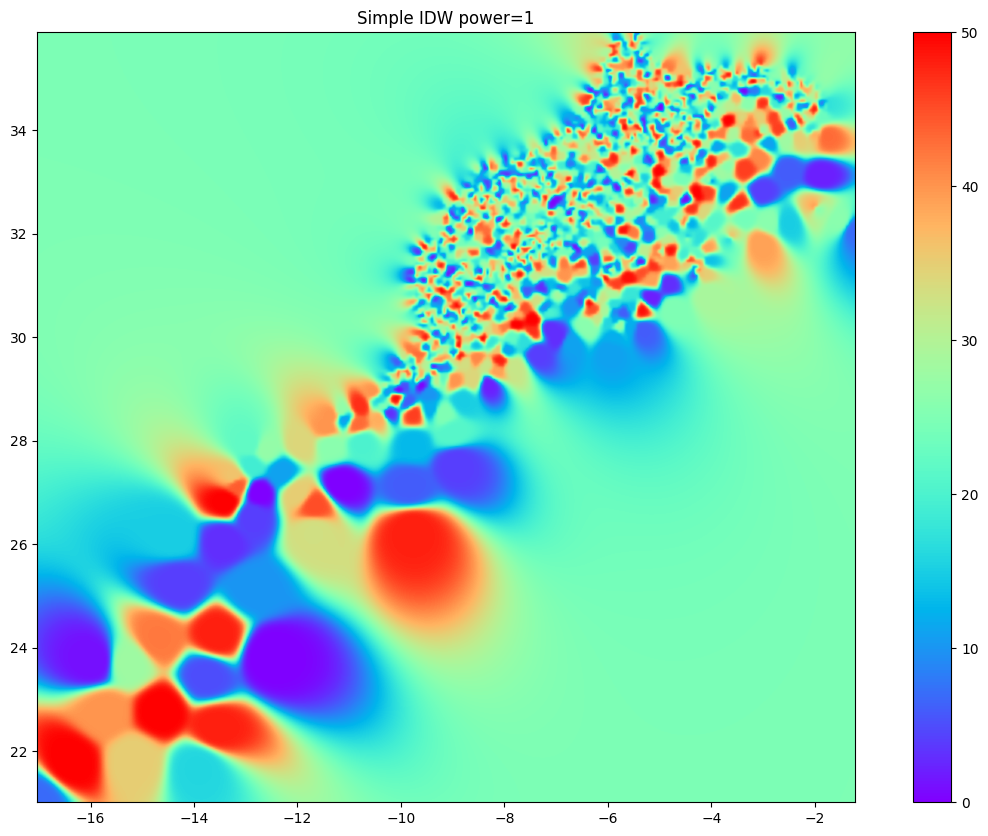

In [54]:
# Calculate IDW
grid1 = simple_idw(x,y,z,xi,yi, power=7)
print(grid1)
grid1 = grid1.reshape((ny, nx))
print(grid1)
grid1=grid1[::-1, :]

plot(x,y,z,grid1)
plt.title('Simple IDW power=1')

plt.show()



In [55]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

In [56]:
def read_geotiff(filename):
    ds = gdal.Open(filename)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    return arr, ds

In [69]:
def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32
    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)
    pixel_size_x = abs(in_ds.GetGeoTransform()[1])
    pixel_size_y = abs(in_ds.GetGeoTransform()[5])
    print("Pixel Size X:", pixel_size_x)
    print("Pixel Size Y:", pixel_size_y)
    print("Input Array Shape:", arr.shape)
    print("Output Array Shape:", out_ds.GetRasterBand(1).ReadAsArray().shape)
    print("in_ds.GetGeoTransform()",in_ds.GetGeoTransform())
    print("in_ds.GetProjection()",in_ds.GetProjection())
    print("Data Range:", in_ds.GetRasterBand(1).ReadAsArray().min(), in_ds.GetRasterBand(1).ReadAsArray().max())


Pixel Size X: 0.05953384189600001
Pixel Size Y: 0.05953384189600001
Input Array Shape: (251, 266)
Output Array Shape: (251, 266)
in_ds.GetGeoTransform() (-17.057973193947966, 0.05953384189600001, 0.0, 35.92340047694805, 0.0, -0.05953384189600001)
in_ds.GetProjection() GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Data Range: 5.25 43.75


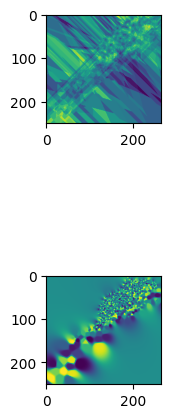

In [70]:
nlcd01_arr, nlcd01_ds = read_geotiff("/content/tif1.tif")


nlcd_changed = grid1

write_geotiff("nlcd_changeddawedyyyhibaa.tif", nlcd_changed, nlcd01_ds)

plt.subplot(311)
plt.imshow(nlcd01_arr)



plt.subplot(313)
plt.imshow(nlcd_changed)

plt.show()

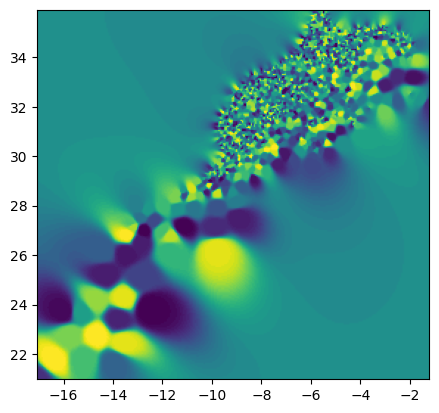

In [61]:
import rasterio
from rasterio.plot import show

with rasterio.open("/content/nlcd_changeddawedyyyhibaa.tif") as src:
    show(src)

In [18]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 52.8 MB/s eta 0:00:00


In [63]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd

In [73]:
inshp = '/content/HHHH.shp'
inRas = '/content/nlcd_changeddawedyyyhibaa.tif'
outRas = '/content/tif222hibahh.tif'


Vector=gpd.read_file(inshp)



with rasterio.open(inRas) as src:
    #Vector=Vector.to_crs(src.crs)
    # print(Vector.crs)
    out_image, out_transform=mask(src,Vector.geometry,crop=True)
    out_meta=src.meta.copy() # copy the metadata of the source DEM

out_meta.update({
    "driver":"Gtiff",
    "height":out_image.shape[1], # height starts with shape[1]
    "width":out_image.shape[2], # width starts with shape[2]
    "transform":out_transform
})

with rasterio.open(outRas,'w',**out_meta) as dst:
    dst.write(out_image)

In [81]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask

inshp = '/content/HHHH.shp'
inRas = '/content/tif1.tif'
outRas = '/content/aah.tif'

# Read the shapefile
Vector = gpd.read_file(inshp)
if not Vector.crs:
    print("CRS not defined for the GeoDataFrame. Setting it to EPSG:4326.")
    Vector = Vector.set_crs("EPSG:4326")

with rasterio.open(inRas) as src:
    # Ensure the shapefile and raster have the same CRS
    Vector = Vector.to_crs(src.crs)

    # Clip the raster using the shapefile geometry
    out_image, out_transform = mask(src, Vector.geometry, crop=True)
    out_meta = src.meta.copy()

# Update metadata
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Write the clipped raster to a new GeoTIFF
with rasterio.open(outRas, 'w', **out_meta) as dst:
    dst.write(out_image)



CRS not defined for the GeoDataFrame. Setting it to EPSG:4326.
